# Synthetic Quantum Electrodynamics via Generative AI
# Part V/V -- Deep Inverse Problems

$
\large
\text{Mikael Mieskolainen}
$

$
\text{Department of Physics and I-X Centre for AI in Science, Imperial College London}
$

$
\tiny
\texttt{m.mieskolainen@imperial.ac.uk}
$

<a href="https://github.com/mieskolainen">github.com/mieskolainen</a>

<br>

$
\text{May, 2025}
$

**Abstract**

Finally, we study inverse problems, i.e. detector efficiency and resolution inversion (unfolding) by training a two-step model approach:

$\text{DeepResolution} \otimes \text{DeepEfficiency}$.

The generative model learns a conditional density $p(\mathbf{x}_G \mid \mathbf{x}_D)$, where $G$ is the generator level and $D$ is the detector level multidimensional observable. DeepEfficiency learns the probability of reconstructing an event $\epsilon_G(\mathbf{x}) \equiv P(y = 1 \mid \mathbf{x}_G)$, given it has been generated.

Formally, this stochastic inversion is

$
\boxed{
\frac{d\sigma}{d\mathbf{x}_G} = \frac{1}{\epsilon(\mathbf{x}_G)} \int p(\mathbf{x}_G \mid \mathbf{x}_D) \, \frac{1}{\mathcal{L}_{\text{int}}} \frac{dN}{d\mathbf{x}_D} \, d\mathbf{x}_D
}
$

where $N$ is the number of events measured and $\mathcal{L}_{\text{int}}$ is the integrated luminosity ($\text{barn}^{-1}$) of the collider data sample, provided by an external measurement.

<br>
<br>

**Outline:**

- [Part I: Physics Theory](tutorial_part_1.ipynb)
- [Part II: AI Theory](tutorial_part_2.ipynb)
- [Part III: Surrogate Simulator](tutorial_part_3.ipynb)
- [Part IV: Amortized Bayesian Posterior](tutorial_part_4.ipynb)
- [Part V: Deep Inverse Problems](tutorial_part_5.ipynb)

<br>

<div style="display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px;">
  <img src="img/scattering_simulation.jpeg" style="width: 49%; height: auto;">
  <img src="img/OU_simulation.jpeg" style="width: 49%; height: auto;">
</div>

> **Compatibility: Use VSCode with Jupyter extension (better LaTex rendering) or JupyterLab. Hit refresh [F5] if the notebook freezes.**


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Run this first if using Colab
"""
!git clone https://github.com/mieskolainen/AIMS25.git
%cd AIMS25
"""
import sys
sys.path.append('./xaims')

# !pip install -r requirements.txt

In [3]:
import numpy as np
import torch
import torch.optim as optim

# For reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Use device: GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    !nvidia-smi
else:
    device = torch.device("cpu")

print("Using device:", device)

Sat May 17 03:45:10 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   30C    P0    71W / 500W |   8547MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   

<br>

---

## Forward Problem


We generate training data with QED MC Event Generator + Fast Detector Simulation.

HEP experiments use <a href="https://geant4.web.cern.ch/">GEANT4 simulations</a> with a full custom detector geometry and material description + exactly the same **reconstruction algorithms**, which turn low-level signals into high-level physics observables, like 3-momentum.

Alternatively, fast parametrized simulations very much like the one below are used. See e.g. <a href="https://github.com/delphes/delphes">Delphes FastSim</a>. Conditional Generative AI is currently under much research to bring GEANT4 like accuracy but Delphes like speed for detector simulations.


In [4]:
import numpy as np
import torch
from xaims import qedgen

def fastsim(x_gen, theta_min_fiducial, theta_max_fiducial, null_value=-999):
    """
    Parametric toy detector simulation
    """
    x_det = np.zeros_like(x_gen)
    
    # -------------------------------------------------------------
    # These parameters define the fastsim detector (adjust these)
    
    eff_max   = 0.95      # Maximum efficiency
    eff_slope = 1.0       # Steepness of the turn-on curve
    eff_threshold = 4.0   # pT value where efficiency ≈ 50%
    
    relative_reso = np.array([0.1, 0.1, 0.03])     # Gaussian smearing per component
    relative_bias = np.array([-0.05, 0.15, -0.05]) # Bias per (px, py, pz) component
    
    # -------------------------------------------------------------
    # 1. Efficiency modeling based on pT with a sigmoid efficiency
    # -------------------------------------------------------------
    pT = np.sqrt(x_gen[:,0]**2 + x_gen[:,1]**2)
    
    efficiency = eff_max / (1 + np.exp(-eff_slope * (pT - eff_threshold)))
    reco_label = np.random.rand(n_events) < efficiency
    
    # -------------------------------------------------------------
    # 2. Apply a scale shift and resolution
    # -------------------------------------------------------------
    for i in range(3):
        
        # Bias shifts the mean value
        x_biased = x_gen[:,i] * (1.0 + relative_bias[i])
        
        # Smearing adds Gaussian noise proportional to the true value
        sigma = relative_reso[i] * x_gen[:, i]
        noise = np.random.randn(x_gen.shape[0]) * sigma
        
        # Final detector-level observable
        x_det[:, i] = x_biased + noise
    
    # Take into account the fiducial box after smearing
    # (if the resolution / bias threw particle outside the fiducial box)
    p          = np.sqrt(np.sum(x_det**2, axis=1))
    theta      = np.arccos(x_det[:,2] / p)
    
    reco_label = reco_label & (theta_min_fiducial < theta) & (theta < theta_max_fiducial)
    
    # Set null value for non-reconstructed
    x_det[reco_label == 0] = null_value
    
    return x_det, reco_label

def sim_wrapper(n_events, sqrts):
    
    # ------------------------------------
    # 1. Event Generator
    # ------------------------------------ 
    
    # Fiducial acceptance cuts
    theta_min_fiducial = np.deg2rad(15.0)
    theta_max_fiducial = np.deg2rad(165.0)
    # ------------------------------------
    
    s     = sqrts**2
    t_min = qedgen.costheta_to_t(costheta=np.cos(theta_max_fiducial), s=s)
    t_max = qedgen.costheta_to_t(costheta=np.cos(theta_min_fiducial), s=s)

    t_min = max(t_min, -(s - 4*qedgen.m_e**2)) # kinematic limit
    
    x_gen, xs, xs_err, unweight_eff = \
        qedgen.generator(num_events=n_events, sqrts=sqrts, t_min=t_min, t_max=t_max, theory=qedgen.Mode.QED_bhabha)
    
    # ------------------------------------
    # 2. Fast Detector Simulation
    # ------------------------------------
    
    x_det, reco_label = fastsim(x_gen=x_gen,
        theta_min_fiducial=theta_min_fiducial, theta_max_fiducial=theta_max_fiducial)
    
    seen = np.sum(reco_label == 1)
    
    print(f"Total number of training events after detector: {seen} (reconstruction efficiency: {seen / len(reco_label):0.2f})")
    print(f"Shape of event features:", x_det.shape)
    
    return x_gen, x_det, reco_label, xs


In [5]:
# Create training data
#
# O(1e6)++ events for reliable results

n_events = int(1e5)
sqrts    = float(50.0)     # CM energy (GeV)
x_gen, x_det, reco_label, xs = sim_wrapper(n_events=n_events, sqrts=sqrts)

# Convert to torch tensors
x_gen      = torch.as_tensor(x_gen,      dtype=torch.float32, device=device)
x_det      = torch.as_tensor(x_det,      dtype=torch.float32, device=device)
reco_label = torch.as_tensor(reco_label, dtype=torch.int32,   device=device)


Total number of training events after detector: 91249 (reconstruction efficiency: 0.91)
Shape of event features: (100000, 3)


<br>

---

## Neural Network Training


### Preprocessing transforms

In [6]:
from xaims import transforms

def transform_chain(x):
    
    # 1. Create physics coordinate transform and apply
    geom_map   = transforms.PhysicsTransform(transverse_mode='pt', longitudinal_mode='pz').to(device)
    x_norm     = geom_map.forward(x)
    
    # 2. Create standardization transform and apply
    x_mean     = x_norm.mean(dim=0, keepdim=True)
    x_std      = x_norm.std(dim=0, keepdim=True)
    zscore_map = transforms.ZScoreTransform(x_mean, x_std).to(device)
    x_norm     = zscore_map.forward(x_norm)
    
    # 3. Chain to a total transform map to reverse later in the inference
    return transforms.CompositeTransform([geom_map, zscore_map]).to(device), x_norm
    
    # No transforms
    #return transforms.CompositeTransform([]).to(device), x


In [7]:
# For DeepEfficiency
pre_transform_gen_all, mc_events_gen_all = transform_chain(x=x_gen)

# For DeepResolution
pre_transform_gen, mc_events_gen = transform_chain(x=x_gen[reco_label == 1])
pre_transform_det, mc_events_det = transform_chain(x=x_det[reco_label == 1])

x_dim = mc_events_gen.shape[-1]


### Train DeepEfficiency 

This model is trained with a BCE classifier loss to learn a fiducial reconstruction efficiency probability

$
\mathcal{P}(y=1 \mid \mathbf{x}_{G}): \mathbb{R}^D \rightarrow [0,1]
$

i.e. the detector efficiency of reconstructing a generator level event $\mathbf{x}_{G}$. The target labels are $y = \{0, 1\}$ for not reconstructed and reconstructed, respectively. This can be understood as a multi-dimensional kinematics dependent Bernoulli process probability estimator.

> The training input is all generator level events which are inside the fiducial box. We only generated events inside the fiducial acceptance box, i.e. no further **kinematic cuts** are required.

> Because the training events are at the generator level, in the inference stage we assume this to be applied *after* the DeepResolution unfolding inversion which gives us $\mathbf{x}_D \rightarrow \hat{\mathbf{x}}_G$.

> If the detector resolution is very good, $\mathbf{x}_G \sim \mathbf{x}_D$, no unfolding is needed. However, even in that case it may be useful to do "generative inversion" if $\mathbf{x}_D$ is defined in a different space (e.g. low-level observables) than $\mathbf{x}_G$ (e.g. momentum space), because the space of $\mathbf{x}_G$ and $\mathbf{x}_D$ or their dimensions do not need to be the same with conditional AI models.

<a href="https://arxiv.org/abs/1809.06101">Mieskolainen, *DeepEfficiency -- optimal efficiency inversion in higher dimensions at the LHC*, [arXiv:1809.06101]</a>


In [8]:
# Model wrapper

class DeepEfficiencyNet(torch.nn.Module):
    def __init__(self, model):        
        super().__init__()
        self.model = model
        self.lossfunc = torch.nn.BCELoss(reduction="none")
        # BCEWithLogitsLoss more numerically stable option (remove sigmoid from the network output)
        
    def forward(self, x):
        return self.model(x)
    
    def loss(self, x, target):
        pred = self.forward(x)
        if target.dim() == 1:
            target = target.unsqueeze(1)
        return self.lossfunc(pred, target)


Number of model parameters: 5.1E+04


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/epoch, train_loss=0.2725, lr=0.000006, val_loss=0.2724]


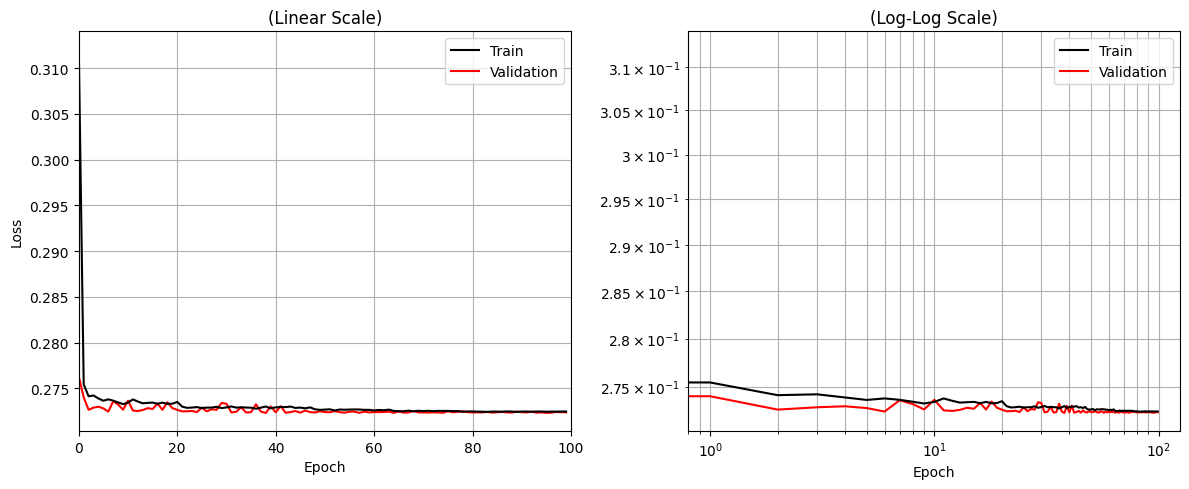

In [9]:
# Train network

from xaims import aux, visualize

lr           = 1e-4
weight_decay = 1e-3

n_epochs     = 100
batch_size   = 256
train_loader, val_loader = aux.split_loaders(X=mc_events_gen_all, y=reco_label.to(torch.float32), frac=0.8, batch_size=batch_size)

# DeepEfficiency model
model_DE = DeepEfficiencyNet(aux.ResidualMLP(in_dim=x_dim, out_dim=1,
            **{"hidden_dim": [128, 128, 128, 128], "act": "gelu", "layer_norm": True, "apply_sigmoid": True})).to(device)

# Optimizer and scheduler
optimizer_DE  = optim.AdamW(model_DE.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_DE  = optim.lr_scheduler.ReduceLROnPlateau(optimizer_DE, 'min', factor=0.5, patience=10, min_lr=1e-6)

# Returns the best validation loss model
losses_DE, model_DE = aux.train_wrapper(model=model_DE, optimizer=optimizer_DE, scheduler=scheduler_DE,
                                  train_loader=train_loader, val_loader=val_loader, n_epochs=n_epochs)

fix,axs = visualize.plot_losses(train_losses=losses_DE[0], val_losses=losses_DE[1])


### Train DeepResolution aka Generative Unfolding

The generative AI model, here chosen as DDPM diffusion, learns to sample *unfolded* events from the conditional density

$
\hat{\mathbf{x}}_{G} \sim p(\mathbf{x}_{G} \mid \mathbf{x}_{D})
$

for given a reconstructed detector level event $x_D$. Then we reweight these events using DeepEfficiency.

For various AI-based unfolding strategies, see:

<a href="https://arxiv.org/abs/2404.18807">Huetsch et al. *The Landscape of Unfolding with Machine Learning*, [arXiv:2404.18807]</a>

**Note**: You can change the generative model to a continuous-time SDE diffusion also, or normalizing flows.

Number of model parameters: 2.1E+04


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:19<00:00,  1.27s/epoch, train_loss=0.0890, lr=0.000010, val_loss=0.0982]


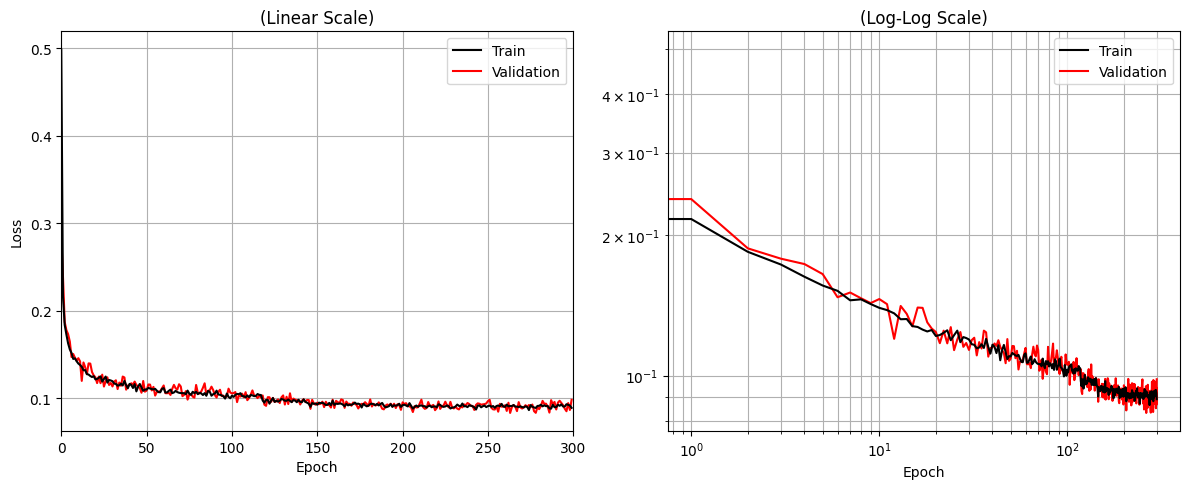

In [10]:
from xaims import ddpm, aux

lr           = 1e-3
weight_decay = 1e-3

n_epochs   = 300
batch_size = 256

train_loader, val_loader = aux.split_loaders(X=mc_events_gen, y=mc_events_det, frac=0.8, batch_size=batch_size)

# DeepResolution model
time_embed_dim  = 8
model_ddpm = ddpm.DDPM(
    x_dim           = x_dim,
    cond_dim        = x_dim,
    beta_start      = 1e-4,
    beta_end        = 0.02,
    diffusion_steps = 1000,
    time_embed_dim  = 8,
    nnet            = aux.ResidualMLP(in_dim=x_dim + time_embed_dim + x_dim, out_dim=x_dim,
                               **{"hidden_dim": [96, 96, 96], "layer_norm": True, "act": "silu", "dropout": 0})
    #nnet           = aux.VectorTransformer(in_dim=x_dim + time_embed_dim + c_dim, out_dim=x_dim,
    #                           **{"d_model": 32, "nhead": 4, "num_layers": 2, "dim_feedforward": 128, "dropout": 0.0})
).to(device)

# Optimizer and scheduler
optimizer_ddpm = optim.AdamW(model_ddpm.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_ddpm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ddpm, 'min', factor=0.5, patience=20, min_lr=1e-5)

# Returns the best validation loss model
losses_ddpm, model_ddpm = aux.train_wrapper(model=model_ddpm, optimizer=optimizer_ddpm, scheduler=scheduler_ddpm,
                              train_loader=train_loader, val_loader=val_loader, n_epochs=n_epochs)

fig,axs = visualize.plot_losses(train_losses=losses_ddpm[0], val_losses=losses_ddpm[1])


<br>

---
## Inverse Problem


### Generate MC test sample



In [11]:
# Create training data with MC

n_events = int(1e6)
# sqrts needs to be the same as in the training training

x_gen_tst, x_det_tst, reco_tst, xstot_test = sim_wrapper(n_events=n_events, sqrts=sqrts)

# Convert to torch tensors
x_gen_tst = torch.as_tensor(x_gen_tst, dtype=torch.float32, device=device)
x_det_tst = torch.as_tensor(x_det_tst, dtype=torch.float32, device=device)
reco_tst  = torch.as_tensor(reco_tst,  dtype=torch.int32,   device=device)


Total number of training events after detector: 910519 (reconstruction efficiency: 0.91)
Shape of event features: (1000000, 3)


### Resolution Inversion with DeepResolution

As a generative sampling based inverse procedure, we generate unfolded generator events with the trained AI generator:

$
\{ \hat{\mathbf{x}}_{G,j}^{(i)} \}_{j=1}^K \sim p(\mathbf{x}_G \mid \mathbf{x}_D^{(i)}), \quad \forall \, i = 1, \dots, N
$

This is repeated $K$ times for each measured scattering event $\mathbf{x}_D^{(i)}$ and $N$ is the total number of reconstructed (measured) events. Events are assumed to be independent, identically distributed (iid). Then **per event** mean estimate and its sampling variance can be obtained as

$
\langle \hat{\mathbf{x}}_G^{(i)} \rangle = \frac{1}{K} \sum_{j=1}^K \hat{\mathbf{x}}_{G,j}^{(i)}
$

$
\mathrm{Var}\bigl(\hat{\mathbf{x}}_G^{(i)}\bigr) = \frac{1}{K}\sum_{j=1}^K \left(\hat{\mathbf{x}}_{G,j}^{(i)} - \langle \hat{\mathbf{x}}_G^{(i)}\rangle\right)^{2} = \frac{1}{K}\sum_{j=1}^K \left( \hat{\mathbf{x}}_{G,j}^{(i)} \right)^2 - \left\langle \hat{\mathbf{x}}_G^{(i)}\right\rangle^{2}.
$

However, at the full **distribution level**, a more consistent approach in terms of full sampling density is to concatenate all $K$ samples and then reweight by $1/K$ when constructing e.g. histograms to normalize them correctly.

In [12]:
## Sampling wrapper

from xaims import aux

def sample_from_ddpm(num_samples: int, cond: torch.Tensor, device='cpu'):
    
    model_ddpm.eval() #!
    
    with torch.no_grad():
        cond = aux.expand_dim(cond, num_samples=num_samples, device=device) # Expand batch dimensions
        cond_norm = pre_transform_det.forward(cond) # Forward processing
        
        x_gen_hat = model_ddpm.sample(num_samples, cond_norm)
        x_gen_hat = pre_transform_gen.reverse(x_gen_hat) # Revert pre-processing
    
    return x_gen_hat


In [13]:
## Sample posterior values for the full dataset K times

from tqdm import tqdm

K = 1 # Now use 1 for convinience
N = torch.sum(reco_tst)
cond = x_det_tst[reco_tst == 1]

values = []
for _ in tqdm(range(K)):
    values.append(sample_from_ddpm(N, cond=cond, device=device))

method = 1

# Concatenate all samples, i.e. we have K x N events
if method == 1:
    x_hat  = torch.cat(values, dim=0)
    w_reso = torch.ones(x_hat.shape[0], dtype=torch.float32, device=device) / K # This is just to rescale statistics

# Stack into shape [K, N, dim] and average over the first axis, we get N events
if method == 2:
    x_hat     = torch.stack(values, dim=0).mean(dim=0)
    x_hat_std = torch.stack(values, dim=0).std(dim=0)
    w_reso    = torch.ones(x_hat.shape[0], dtype=torch.float32, device=device) # Unity

print(x_hat.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.76s/it]

torch.Size([910519, 3])


### Efficiency Inversion with DeepEfficiency

We obtain per event efficiency correction inverse weights with

$
\boxed{
w_i = \frac{1}{\mathcal{P}(\hat{\mathbf{x}}_G^{(i)})}, \; \forall i = 1, \dots, N
}
$

These weights can be then used in a downstream analysis, e.g. with weighted histograms and allow arbitrary observables to be corrected simultaneously. 

With histograms easiest is to do weighted histogramming twice with weights and weights squared, which yields an event count histogram and a variance histogram, per observable. This is done in the visualization code.

> **Note**: This is not a density ratio estimation with a classifier network. In that case weights would are computed via $w_i = \mathcal{P}_i(\mathbf{x}) / (1 - \mathcal{P}_i(\mathbf{x})) \in [0, \infty) $, or the inverse of that, depending on the application.


In [14]:
# DeepEfficiency with a minimum probability cut-off regularization (alpha)

def deepefficiency_weights(x, alpha=1e-5):
    
    model_DE.eval()
    
    with torch.no_grad():
        x          = pre_transform_gen_all.forward(x)
        prob_hat   = model_DE(x).squeeze()        
    
    # Inverse probability weights
    return 1.0 / torch.clip(prob_hat, alpha, None)

w_eff = deepefficiency_weights(x_hat)


### Basic visualizations

We use simply histogram count based normalizations in these visualizations.

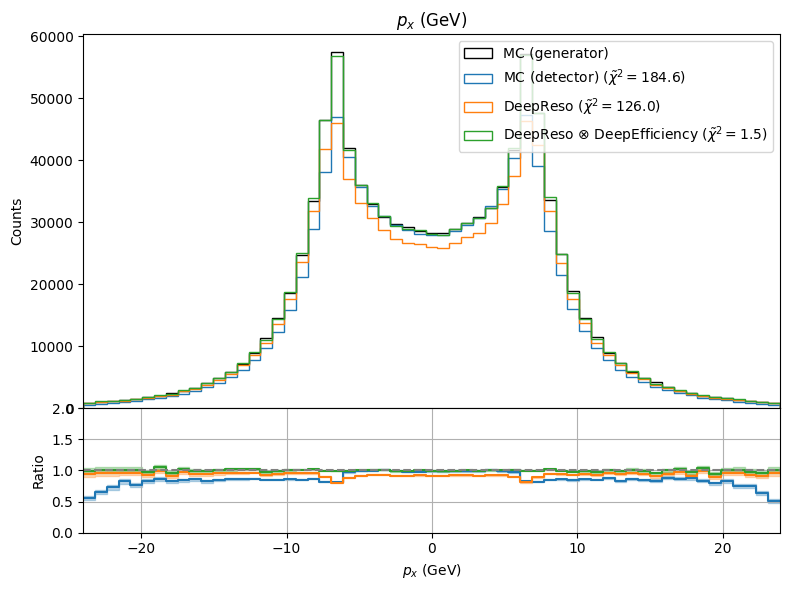

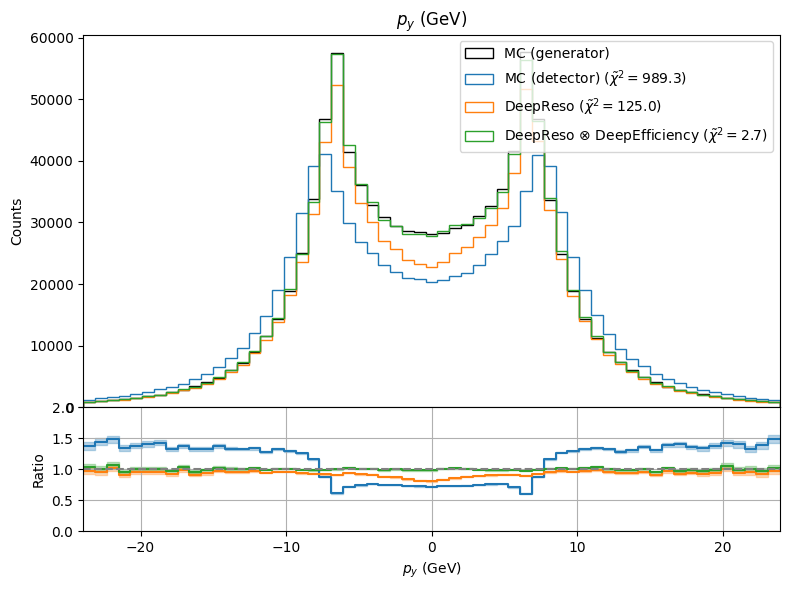

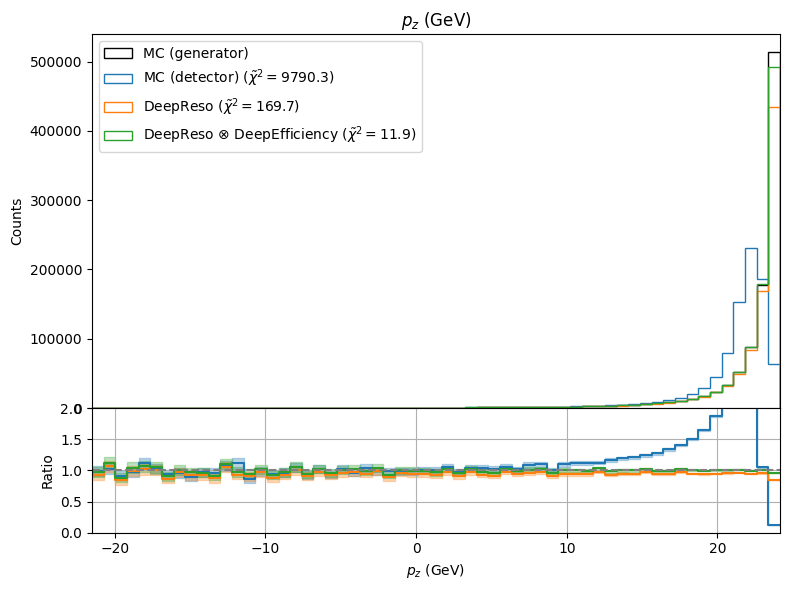

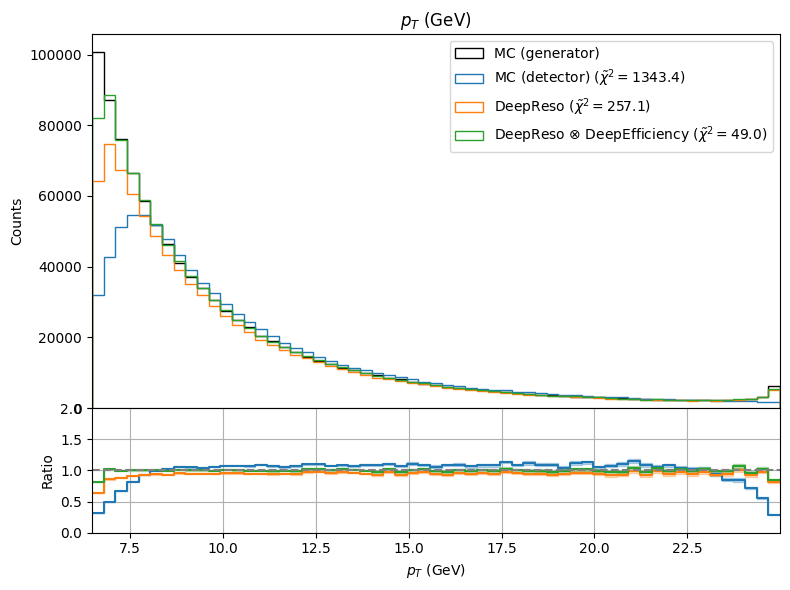

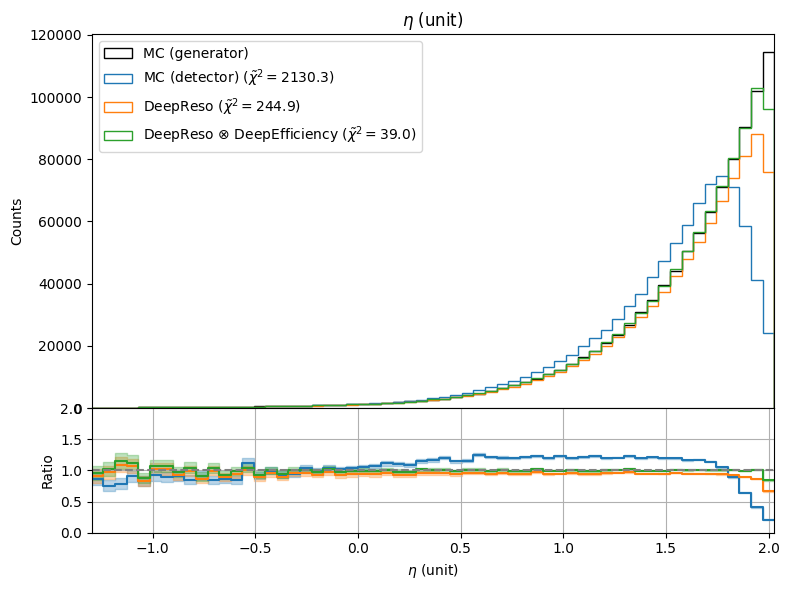

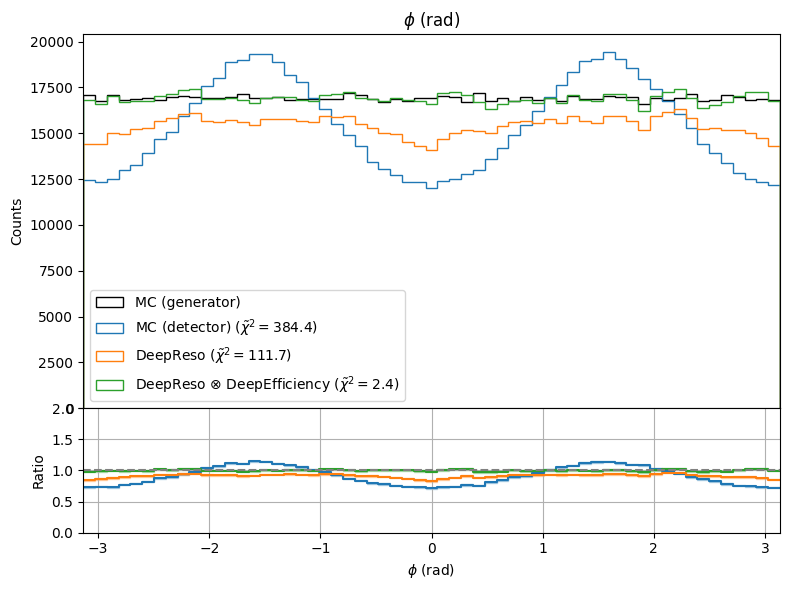

In [15]:
# Example usage:

from xaims import qedgen, visualize

data = {
    'MC (generator)': {'x': x_gen_tst,                   'w': None},
    'MC (detector)':  {'x': x_det_tst[reco_tst == 1],    'w': None},
    'DeepReso':       {'x': x_hat,                       'w': w_reso},    
    'DeepReso $\\otimes$ DeepEfficiency':  {'x': x_hat,  'w': w_reso * w_eff},
}

visualize.plot_inversion_comparisons(
     data,
     reference_key='MC (generator)',
     extract_observables=qedgen.extract_observables,
     nbins=60
)


In [16]:
"""
# Debug

data = {
    'MC (generator)': {'x': x_gen_tst[reco_tst == 1],    'w': None},
    'MC (detector)':  {'x': x_det_tst[reco_tst == 1],    'w': None},
    'DeepReso':       {'x': x_hat,                       'w': w_reso},    
    'DeepReso $\\otimes$ DeepEfficiency':  {'x': x_hat,  'w': w_reso * w_eff},
}

visualize.plot_inversion_relative_error(
     data,
     reference_key='MC (generator)',
     extract_observables=qedgen.extract_observables,
     nbins=60
)
"""

"\n# Debug\n\ndata = {\n    'MC (generator)': {'x': x_gen_tst[reco_tst == 1],    'w': None},\n    'MC (detector)':  {'x': x_det_tst[reco_tst == 1],    'w': None},\n    'DeepReso':       {'x': x_hat,                       'w': w_reso},    \n    'DeepReso $\\otimes$ DeepEfficiency':  {'x': x_hat,  'w': w_reso * w_eff},\n}\n\nvisualize.plot_inversion_relative_error(\n     data,\n     reference_key='MC (generator)',\n     extract_observables=qedgen.extract_observables,\n     nbins=60\n)\n"

**Pay attention to where do the detector smearing (shift) effects manifest (e.g. reconstructed higher than generated)**


<br>

---

## ** Exercise: Going Deeper with the Inverse Problem **

The folding and efficiency loss **forward process** is described by a formal integral equation

$
\frac{d\sigma}{d\mathbf{x}_D} = \int p(\mathbf{x}_D \mid \mathbf{x}_G)\, \epsilon(\mathbf{x}_G)\, \frac{d\sigma}{d\mathbf{x}_G} \, d\mathbf{x}_G,
$

where $p(\mathbf{x}_D \mid \mathbf{x}_G)$ is the conditional density for observing $\mathbf{x}_D$ given generator-level truth $\mathbf{x}_G$, and $\epsilon(\mathbf{x}_G)$ is the probability that an event $\mathbf{x}_G$ is reconstructed.

**Task 1:** Visualize the folding process conditional density (folding kernel) and its inverse (DeepResolution), and the same for the efficiency function (DeepEfficiency). Because these are multidimensional objects, do it e.g. per observable $(p_x, p_y, p_z)$ and $(\eta, p_T, \phi)$ using 2D histograms.

In [17]:
# Implement here.

**Task 2:** Visualize where the generative model is confident or uncertain. For this, you need to sample multiple times per detector level event, to get a distribution of AI estimates.

In [18]:
# Implement here.

**Task 3:** Discuss regularization properties, singularities, integration domain issues, factorization of the resolution and efficiency maps and other possibly **ill-posed properties** of inverting this stochastic integral equation?

In [19]:
# Your critical discussion here.

<br>

---
## Check your knowledge

1. **What is the purpose of DeepEfficiency inversion?**
2. **What is the purpose of DeepResolution inversion?**
3. **Why do we need both?**
4. **Using high-dimensional methods instead of 1D inversion, we minimize the event generator dependence on the data inversion. Why so?**
5. **What to do when the detector simulation does not match reality? (calibration processes)**
6. **What to do when the efficiency goes to zero, i.e. we have a hole inside our multidimensional fiducial box definition? (how to re-define)**
